In [1]:
import pandas as pd
import numpy as np
import nltk, gensim, spacy
from nltk.util import ngrams
from scipy import sparse
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import re
from textblob import TextBlob
from sklearn.feature_extraction import text
import string
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from wordcloud import *
from textblob import TextBlob
import pickle

In [2]:
bank_df = pd.read_excel("BankReviews.xlsx",sheet_name="BankReviews")

In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [4]:
bank_complaint_df = bank_df.copy()
bank_complaint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


#### Trying out TextBlob Sentiment analysis function on reviews to see if we can use it to classify reviews, basen on polarity score 

    - polarity <0 = negative
    - polarity >0 = positive
    - polarity ==0 = neutral)

In [5]:
#Ex 1
print("Rating: ", bank_df.Stars.loc[43])
rev = bank_df.Reviews.loc[43]
print("Review: ",rev )

analyze = TextBlob(rev)
print("Polarity: ",analyze.polarity)

Rating:  1
Review:  This loan started off quite well. Our rep, Donna, was friendly and quick to respond to questions. She clearly explained how things would unfold, and it all sounded great. What I didn't count on was that the Bank never kept a single promise she made. I had the same problem with this Bank 15 or more times. I would ask for assurance about something, Donna would respond that things would be completed as I wished, and her promise was violated by the Bank EVERY SINGLE TIME. For example, in our first or second conversation, I explained to Donna that my wife would be traveling out of the country 11 weeks after beginning the loan process. Would it be a problem to get the loan closed before that? Not at all, she said. We should close several weeks before my wife's departure. 11 weeks later, the Bank was not ready to close. How did that happen? Donna would ask us to email documentation, which we would email back within 2-12 hours, depending on the occasion. Donna would then as

In [6]:
#Ex 2
print("Rating: ", bank_df.Stars.loc[18])
rev = bank_df.Reviews.loc[18]
print("Review: ",rev )

analyze = TextBlob(rev)
print("Polarity: ",analyze.polarity)

Rating:  1
Review:  A good rate but a very frustrating process, constant delays, decisions made then changed, overwhelmed underwriting team with 3 week back log, rookie mistake related to Texas law that caused an additional 2 week wait. Closing happened almost 6 weeks after it should have. Courteous and professional, but not very knowledgeable and no sense of urgency. Would not recommend
Polarity:  0.09749999999999999


In [7]:
#Ex 3
print("Rating: ", bank_df.Stars.loc[53])
rev = bank_df.Reviews.loc[53]
print("Review: ",rev )

analyze = TextBlob(rev)
print("Polarity: ",analyze.polarity)

Rating:  5
Review:  
We were initially pretty skeptical about refinancing our home.  We’ve had personal and family issues that devastated our credit to the point where we felt that it would be a waste of time since we’d never be approved.  However, a real need arose when Dad’s declining health demanded we make room in our home so we can keep him close to us and give him the care he needs.  We weren’t sure what to expect from Patrick G at Reliance, but we were soon reassured and thoroughly delighted when Pat informed us that we were eligible and that he’d walk us through the entire process personally!  There simply are no superlatives sufficient to thank you for your fantastic guidance in getting our home refinanced!  You took what we assumed would be a challenging home refinance and successfully navigated us through the process to a successful conclusion.  In every single step, you proved to be friendly, patient, polite, knowledgeable, professional and consistently available to us.   W

In [8]:
#Ex 4
print("Rating: ", bank_df.Stars.loc[138])
rev = bank_df.Reviews.loc[138]
print("Review: ",rev )

analyze = TextBlob(rev)
print("Polarity: ",analyze.polarity)

Rating:  5
Review:  
I am writing this review to share what ended up being an unpleasant experience with Kirk Gay and Pacific Beneficial Mortgage to other potential customers. 

I am a first time homebuyer and was originally going to go with a local mortgage broker for my loan, but wanted to shop around for a potential better rate, so I used LendingTree which is how Kirk contacted me. My original lender had offered to pay for my home appraisal in writing, and, wanting to compete, Kirk said he would pay for the appraisal (which he stated in writing) and asked for the letter the other lender had provided so he could get permission to have Pacific Beneficial pay for my appraisal. Kirk confirmed I would not be paying for the appraisal and was very happy with what Kirk was doing to accommodate me as a customer. However, when I closed on the home, the cost of the appraisal was on my Final Buyer’s Statement ($525). As Kirk had said that I would not be paying for the appraisal, I thought I wou

**Conclusion:** The sentiment analysis function isn't performing as well when there is a big paragraph to parse. A lot of negative reviews are passing with +ve polarities. Hence, we would use a Regression technique in conjunction with the Stars column to determine the Sentiment of a review

In [9]:
rev_df = pd.DataFrame(columns=["Reviews","is_Good"])
rev_df["Reviews"] = bank_df["Reviews"]
rev_df["is_Good"] = bank_df["Stars"].apply(lambda x: 1 if x == 5 else 0)

rev_df.head()

,Reviews,is_Good
0,"Great job, Wyndham Capital! Each person was pr...",1
1,Matthew Richardson is professional and helpful...,1
2,We had a past experience with Wyndham Mortgage...,1
3,We have been dealing with Brad Thomka from the...,1
4,I can't express how grateful I am for the supp...,1


In [10]:
rev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
Reviews    505 non-null object
is_Good    505 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.0+ KB


### Cleaning Data

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [13]:
# lower text
text = rev_df.Reviews.loc[92].lower()
# tokenize text and remove puncutation
text = [word.strip(string.punctuation) for word in text.split(" ")]
# remove stop words
stop = stopwords.words('english')
text = [x for x in text if x not in stop]
# remove empty tokens
text = [t for t in text if len(t) > 0]

pos_tag(text)

[('\r\nin', 'JJ'),
 ('response', 'NN'),
 ('previous', 'JJ'),
 ('review', 'NN'),
 ('greg', 'NN'),
 ('bellezza', 'NN'),
 ('reliance', 'NN'),
 ('capital', 'NN'),
 ('refund', 'NN'),
 ('appraisal', 'NN'),
 ('fee.\r\n', 'NN')]

In [14]:
#remove \r\n characters from the review
text = [t.replace('\n', ' ').replace('\r', '') for t in text]
pos_tag(text)

[(' in', 'JJ'),
 ('response', 'NN'),
 ('previous', 'JJ'),
 ('review', 'NN'),
 ('greg', 'NN'),
 ('bellezza', 'NN'),
 ('reliance', 'NN'),
 ('capital', 'NN'),
 ('refund', 'NN'),
 ('appraisal', 'NN'),
 ('fee. ', 'NN')]

In [15]:
#Lemmatize words based on POS tagging
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def clean_texts(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove stop words
    text = [x for x in text if x not in stop]
    #remove \r\n characters from the review
    text = [t.replace('\n', ' ').replace('\r', '') for t in text]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text based on the context of word placement in review
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [17]:
rev_df["Reviews_clean"] = rev_df["Reviews"].apply(lambda x: clean_texts(x))

In [18]:
rev_df.Reviews_clean.loc[92]

' in response previous review greg bellezza reliance capital refund appraisal fee. '

## Section 1: Sentiment Analysis
### Using Vader package 

We use this package because for each text, Vader returns 4 values:
- neutrality score
- positivity score
- negativity score
- overall score that summarizes the previous scores


In [19]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pratiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
# add sentiment anaylsis columns

sid = SentimentIntensityAnalyzer()
rev_df["sentiments"] = rev_df["Reviews"].apply(lambda x: sid.polarity_scores(x))
# modifying sentiments so that each score has its own column
rev_df = pd.concat([rev_df.drop(['sentiments'], axis=1), rev_df['sentiments'].apply(pd.Series)], axis=1)

In [21]:
rev_df.head()

,Reviews,is_Good,Reviews_clean,neg,neu,pos,compound
0,"Great job, Wyndham Capital! Each person was pr...",1,great job wyndham capital person professional ...,0.000,0.703,0.297,0.8011
1,Matthew Richardson is professional and helpful...,1,matthew richardson professional helpful help f...,0.000,0.703,0.297,0.8516
2,We had a past experience with Wyndham Mortgage...,1,past experience wyndham mortgage would without...,0.000,0.794,0.206,0.9595
3,We have been dealing with Brad Thomka from the...,1,deal brad thomka beginning start stressful tim...,0.018,0.756,0.226,0.9818
4,I can't express how grateful I am for the supp...,1,can't express grateful support zach provide fa...,0.040,0.861,0.099,0.5569


In [22]:
rev_df.loc[18]
# The compounded scoring looks quite promising

Reviews          A good rate but a very frustrating process, co...
is_Good                                                          0
Reviews_clean    good rate frustrate process constant delay dec...
neg                                                          0.195
neu                                                          0.692
pos                                                          0.113
compound                                                   -0.7615
Name: 18, dtype: object

Next we will **vectorize the texts** in the review to have a better understanding of which words are similar in nature. This will be done in the context of the sentence and hence will be of more value to us.

In [ ]:
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(rev_df["Reviews_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(docs, vector_size=10, window=2, min_count=1, workers=8)

# transform each document into a vector data
doc2vec_df = rev_df["Reviews_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
rev_df = pd.concat([rev_df, doc2vec_df], axis=1)

rev_df.head()

Finally we add the **TF-IDF (Term Frequency - Inverse Document Frequency)** values for every word and every document. 


We add TF-IDF columns for every word that appear in at least 5 different texts(since dataset is small) to filter some of them and reduce the size of the final output.

In [ ]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 5)
tfidf_result = tfidf.fit_transform(rev_df["Reviews_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = rev_df.index
rev_df = pd.concat([rev_df, tfidf_df], axis=1)

rev_df.head()

**Checking if the sentiments look fine**

In [23]:
# highest positive sentiment reviews
rev_df.sort_values("compound", ascending = False)[["Reviews", "compound"]].head(10)

,Reviews,compound
109,"\r\nI can't say enough about Adam, Bill and Pa...",0.9960
108,\r\nI can't say enough about Adam and Pac Ben....,0.9960
53,\r\nWe were initially pretty skeptical about r...,0.9950
130,"\r\nWhen we put an offer on in our home, our r...",0.9936
129,"\r\nWhen we put an offer on in our home, our r...",0.9936
396,\r\nA friend of mine told me that he just refi...,0.9930
343,\r\nWe have bought and sold multiple propertie...,0.9923
250,"\r\nThis was my first home purchas; however, w...",0.9917
280,\r\nI started a process for a mortgage loan wi...,0.9909
288,\r\nWent above and beyond to make sure I had a...,0.9872


In [43]:
rev_df.sort_values("compound", ascending = True)[["Reviews", "compound"]].head(10)

,Reviews,compound
233,\r\nThe Interest rate offered and time to clos...,-0.9372
220,\r\nMiserable experience. They screwed up ever...,-0.8939
40,Miserable experience. They screwed up everythi...,-0.8939
492,\r\nMiserable experience. They screwed up ever...,-0.8939
93,\r\nIf you use Reliance First Capitol...DO NOT...,-0.8401
406,\r\nAdam and his team apparently do not commun...,-0.8170
219,\r\nThe closing process for a VA loan went smo...,-0.8019
39,The closing process for a VA loan went smoothl...,-0.8019
491,\r\nThe closing process for a VA loan went smo...,-0.8019
502,\r\nWhat a horrible experience. We have excell...,-0.7882


### New Column: Review_polarity
To define the sentiment of the review from positive, negative or neutral

In [25]:
def get_polarity_class(n):
    if n > 0:
        return "positive"
    elif n < 0:
        return "negative"
    else:
        return "neutral"


rev_df["Review_polarity"] = rev_df["compound"].apply(lambda x: get_polarity_class(x))
rev_df.head()

,Reviews,is_Good,Reviews_clean,neg,neu,pos,compound,Review_polarity
0,"Great job, Wyndham Capital! Each person was pr...",1,great job wyndham capital person professional ...,0.000,0.703,0.297,0.8011,positive
1,Matthew Richardson is professional and helpful...,1,matthew richardson professional helpful help f...,0.000,0.703,0.297,0.8516,positive
2,We had a past experience with Wyndham Mortgage...,1,past experience wyndham mortgage would without...,0.000,0.794,0.206,0.9595,positive
3,We have been dealing with Brad Thomka from the...,1,deal brad thomka beginning start stressful tim...,0.018,0.756,0.226,0.9818,positive
4,I can't express how grateful I am for the supp...,1,can't express grateful support zach provide fa...,0.040,0.861,0.099,0.5569,positive


In [41]:
rev_df[rev_df["Review_polarity"]=="neutral"].to_csv("chk_neutral_review.csv")

In [64]:
# Reviews misclassified when comparing the is_Good column
x = []
for rw in rev_df.itertuples():
    if (rw[2] == 1) & (rw[7]<=0):
        x.append(rw)
    elif (rw[2] == 0) & (rw[7]>=0):
        x.append(rw)


In [74]:
# % of correct classification
print(1-(len(x)/len(rev_df)))

0.8772277227722772


**87% accuracy** in determining the sentiment of the review is a good model

## Section 2: Topic Modelling
### Using LDA model

In [44]:
lst_Review = rev_df["Reviews_clean"].tolist()

In [45]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=7,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            )

data_vectorized = vectorizer.fit_transform(lst_Review)

In [46]:
# Based on best params from GridSearchCV algo
lda_model = LatentDirichletAllocation(n_components=3,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=42,          # Random state
                                      batch_size=50,            # n docs in each learning iter
                                      learning_decay=0.7,
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=50, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [47]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -67458.17168379054
Perplexity:  276.1780831613547
{'batch_size': 50, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### Load model from pickle
```
pickle_in = open("gridsearch_model.pickle","rb")
model = pickle.load(pickle_in)
```

In [48]:
# Best Model
#best_lda_model = model.best_estimator_
best_lda_model = lda_model
# Model Parameters
#print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
#print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Model Perplexity:  276.1780831613547


In [49]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(lst_Review))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.24,0.73,0.03,1
Doc1,0.04,0.92,0.04,1
Doc2,0.25,0.73,0.02,1
Doc3,0.26,0.72,0.01,1
Doc4,0.02,0.96,0.02,1


In [50]:
# Review topics distribution across documents

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.sort_values(by = "Topic Num").reset_index(drop=True)

,Topic Num,Num Documents
0,0,124
1,1,323
2,2,58


#### Topic Keywords

In [51]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,100,aaron,able,absolutely,accept,account,accurate,actual,adam,adan,...,weekend,wife,willing,wonderful,word,work,working,write,wyndham,year
Topic0,2.360710,0.354517,26.361829,5.276008,19.037718,0.359719,3.560991,7.973921,26.094507,2.694316,...,5.683919,21.290964,0.359156,12.713323,14.876047,85.853999,0.339367,7.527886,0.912705,66.306762
Topic1,4.451542,22.251378,27.721409,7.054874,0.343202,0.338316,5.781440,0.340752,0.466334,11.199666,...,1.675315,3.867872,6.612166,0.395281,1.017248,180.446413,8.826414,0.654189,11.928004,1.728619
Topic2,2.022419,0.347102,0.428398,0.342794,0.363266,23.996308,0.386338,0.355796,7.652953,0.349376,...,0.338460,7.972451,0.410048,0.339624,5.307292,21.549690,0.588618,14.077959,0.355374,26.685433


In [52]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,loan,refinance,company,officer,use,time,read,home,work,make,year,close,day,mortgage,recommend
Topic 1,work,process,loan,great,team,recommend,make,home,rate,read,experience,best,time,question,service
Topic 2,loan,bank,email,say,tell,pay,rate,time,ask,closing,week,send,cost,phone,receive


### Topic Conclusion:

What does each topic seems to say about user's concerns?
1. **Topic 0 :** Duration of completing a process
2. **Topic 1 :** The team's interaction throughout the process
3. **Topic 2 :** The availability of the team to answer questions regarding the process


In [54]:
df_document_topic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, Doc0 to Doc504
Data columns (total 4 columns):
Topic0            505 non-null float64
Topic1            505 non-null float64
Topic2            505 non-null float64
dominant_topic    505 non-null int64
dtypes: float64(3), int64(1)
memory usage: 19.7+ KB


In [53]:
df_topic = df_document_topic.copy()
df_topic.rename(index=lambda s: s.replace("Doc",''),inplace = True)
df_topic.index = df_topic.index.astype(int)

In [55]:
df_topic

,Topic0,Topic1,Topic2,dominant_topic
0,0.24,0.73,0.03,1
1,0.04,0.92,0.04,1
2,0.25,0.73,0.02,1
3,0.26,0.72,0.01,1
4,0.02,0.96,0.02,1
5,0.27,0.72,0.01,1
6,0.94,0.03,0.03,0
7,0.52,0.37,0.12,0
8,0.04,0.70,0.25,1
9,0.23,0.33,0.44,2


In [56]:
rev_df = rev_df.assign(Topic=df_topic['dominant_topic']) 
rev_df.head()


,Reviews,is_Good,Reviews_clean,neg,neu,pos,compound,Review_polarity,Topic
0,"Great job, Wyndham Capital! Each person was pr...",1,great job wyndham capital person professional ...,0.000,0.703,0.297,0.8011,positive,1
1,Matthew Richardson is professional and helpful...,1,matthew richardson professional helpful help f...,0.000,0.703,0.297,0.8516,positive,1
2,We had a past experience with Wyndham Mortgage...,1,past experience wyndham mortgage would without...,0.000,0.794,0.206,0.9595,positive,1
3,We have been dealing with Brad Thomka from the...,1,deal brad thomka beginning start stressful tim...,0.018,0.756,0.226,0.9818,positive,1
4,I can't express how grateful I am for the supp...,1,can't express grateful support zach provide fa...,0.040,0.861,0.099,0.5569,positive,1


In [ ]:
# model pickle the GridSearch
pickle_out = open("gridsearch_model.pickle","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

## Section 3: Most frequent Positive and Negative Words

Will utilize the column **is_Good** to classify in this section.<br><br>
**Method** :<br> Identify all the _**adverbs and adjectives**_ in a review since these are the part of speech that define the sentiment of a sentence.
<br>**Wordcloud** map of these words will give us the most frequently used words in positive and negative reviews. 

In [133]:
ref_df = rev_df[rev_df["is_Good"]==1]
positive_rev = pd.concat([ref_df["Reviews_clean"]],axis = 1)
positive_rev.head()

,Reviews_clean
0,great job wyndham capital person professional ...
1,matthew richardson professional helpful help f...
2,past experience wyndham mortgage would without...
3,deal brad thomka beginning start stressful tim...
4,can't express grateful support zach provide fa...


In [135]:
positive_rev.rename(columns = {"Reviews_clean":"Positive_Review"},inplace=True)
positive_rev.head()

,Positive_Review
0,great job wyndham capital person professional ...
1,matthew richardson professional helpful help f...
2,past experience wyndham mortgage would without...
3,deal brad thomka beginning start stressful tim...
4,can't express grateful support zach provide fa...


In [136]:
print(positive_rev["Positive_Review"].loc[0])
analysis = TextBlob(positive_rev["Positive_Review"].loc[0]) 
analysis.sentiment_assessments

great job wyndham capital person professional help move refinance process smoothly thank


Sentiment(polarity=0.43333333333333335, subjectivity=0.45, assessments=[(['great'], 0.8, 0.75, None), (['professional'], 0.1, 0.1, None), (['smoothly'], 0.4, 0.5, None)])

In [137]:
#Confirming the assumption that adverbs and adjectives will define the sentiment of a document

token = nltk.word_tokenize(positive_rev["Positive_Review"].loc[0])
#print(token)
lst = pos_tag(token)
print(type(lst))
lst
p = []
for x in lst:
    if x[1].startswith('J'):
        p.append(x[0])
p

<class 'list'>


['great', 'wyndham', 'professional']

In [128]:
# Getting a list of Sentiment defining words from Postive Review list
senti_wrd = []
for rw in positive_rev.itertuples():
    pos_list = []
    token = []
    
    token = nltk.word_tokenize(rw[1])
    pos_list = pos_tag(token)
    for tup in pos_list:
        if len(tup[0]) > 3:
            if tup[1].startswith('J'):
                senti_wrd.append(tup[0])
            elif tup[1].startswith('R'):
                senti_wrd.append(tup[0])

print(senti_wrd)

['great', 'wyndham', 'professional', 'smoothly', 'professional', 'correct', 'much', 'excellent', 'past', 'extra', 'wrong', 'encountered', 'previous', 'together', 'viable', 'ultimately', 'save', 'highly', 'sincere', 'stressful', 'entire', 'happy', 'extra', 'wrong', 'encountered', 'previous', 'together', 'find', 'viable', 'ultimately', 'save', 'highly', 'sincere', 'less', 'grateful', 'responsiveness', 'professional', 'second', 'educate', 'highly', 'recommend', 'wyndham', 'wyndham', 'original', 'underwrite', 'entire', 'responsive', 'professional', 'smooth', 'timely', 'stressful', 'greatly', 'professionally', 'really', 'overall', 'truly', 'back', 'professionally', 'wonderful', 'patrick', 'answer', 'email', 'immediately', 'sure', 'right', 'portal', 'extremely', 'easy', 'close', 'pleased', 'later', 'loved', 'always', 'answer', 'quickly', 'possible', 'knowledgeable', 'lender', 'negative', 'great', 'quick', 'almost', 'exclusively', 'always', 'really', 'well', 'first', 'first', 'smooth', 'succe

In [131]:
positive = '\n'.join(senti_wrd)
positive

'great\nwyndham\nprofessional\nsmoothly\nprofessional\ncorrect\nmuch\nexcellent\npast\nextra\nwrong\nencountered\nprevious\ntogether\nviable\nultimately\nsave\nhighly\nsincere\nstressful\nentire\nhappy\nextra\nwrong\nencountered\nprevious\ntogether\nfind\nviable\nultimately\nsave\nhighly\nsincere\nless\ngrateful\nresponsiveness\nprofessional\nsecond\neducate\nhighly\nrecommend\nwyndham\nwyndham\noriginal\nunderwrite\nentire\nresponsive\nprofessional\nsmooth\ntimely\nstressful\ngreatly\nprofessionally\nreally\noverall\ntruly\nback\nprofessionally\nwonderful\npatrick\nanswer\nemail\nimmediately\nsure\nright\nportal\nextremely\neasy\nclose\npleased\nlater\nloved\nalways\nanswer\nquickly\npossible\nknowledgeable\nlender\nnegative\ngreat\nquick\nalmost\nexclusively\nalways\nreally\nwell\nfirst\nfirst\nsmooth\nsuccessful\ndefinitely\nusten\nstiff\nscary\nquite\npossibly\nlarge\never\nsimply\nwant\nfaceless\nsure\nausten\ntrue\nausten\nbest\nalso\ntrue\nfirst\nlater\ngive\nhuge\nright\nhappy\

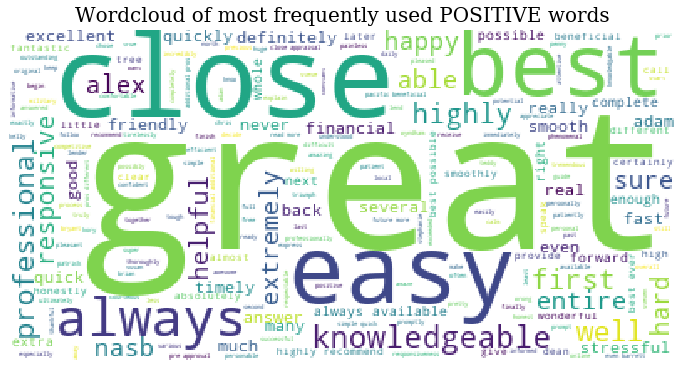

In [142]:
wordcloud = WordCloud(background_color='white',
                     ).generate(positive) 

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.title('Wordcloud of most frequently used POSITIVE words',fontdict={'fontfamily':'serif','fontsize':20})
plt.show()

In [143]:
ref_df = rev_df[rev_df["is_Good"]==0]
negative_rev = pd.concat([ref_df["Reviews_clean"]],axis = 1)
negative_rev.head()

,Reviews_clean
17,bad experience ever like never go process coul...
18,good rate frustrate process constant delay dec...
19,upfront learn mistake trust loan officer zero ...
20,initially mortgage broker friendly assertive p...
21,initially mortgage broker friendly assertive p...


In [144]:
negative_rev.rename(columns = {"Reviews_clean":"Negative_Review"},inplace=True)
negative_rev.head()

,Negative_Review
17,bad experience ever like never go process coul...
18,good rate frustrate process constant delay dec...
19,upfront learn mistake trust loan officer zero ...
20,initially mortgage broker friendly assertive p...
21,initially mortgage broker friendly assertive p...


In [145]:
# Getting a list of Sentiment defining words from Postive Review list
senti_wrd = []
for rw in negative_rev.itertuples():
    pos_list = []
    token = []
    
    token = nltk.word_tokenize(rw[1])
    pos_list = pos_tag(token)
    for tup in pos_list:
        if len(tup[0]) > 3:
            if tup[1].startswith('J'):
                senti_wrd.append(tup[0])
            elif tup[1].startswith('R'):
                senti_wrd.append(tup[0])

print(senti_wrd)

['ever', 'never', 'complete', 'many', 'send', 'underwrite', 'back', 'many', 'send', 'correctly', 'different', 'never', 'awful', 'good', 'constant', 'underwriting', 'back', 'additional', 'almost', 'courteous', 'knowledgeable', 'upfront', 'initially', 'good', 'high', 'favorable', 'good', 'please', 'careful', 'initially', 'friendly', 'assertive', 'fill', 'increasingly', 'difficult', 'call', 'forward', 'initially', 'friendly', 'assertive', 'fill', 'increasingly', 'difficult', 'call', 'forward', 'close', 'smoothly', 'so-called', 'complete', 'automatic', 'clunky', 'website', 'intuitive', 'first', 'automatically', 'debit', 'external', 'however', 'escrow', 'nasb', 'send', 'automatically', 'debit', 'nasb', 'late', 'double', 'current', 'later', 'receive', 'e-mail', 'first', 'speak', 'earlier', 'second', 'automatic', 'adjust', 'various', 'never', 'specifically', 'last', 'agent', 'capable', 'actually', 'miserable', 'imaginable', 'never', 'doghouse', 'much', 'less', 'purchase', 'happy', 'poor', 'po

In [146]:
negative = '\n'.join(senti_wrd)
negative

'ever\nnever\ncomplete\nmany\nsend\nunderwrite\nback\nmany\nsend\ncorrectly\ndifferent\nnever\nawful\ngood\nconstant\nunderwriting\nback\nadditional\nalmost\ncourteous\nknowledgeable\nupfront\ninitially\ngood\nhigh\nfavorable\ngood\nplease\ncareful\ninitially\nfriendly\nassertive\nfill\nincreasingly\ndifficult\ncall\nforward\ninitially\nfriendly\nassertive\nfill\nincreasingly\ndifficult\ncall\nforward\nclose\nsmoothly\nso-called\ncomplete\nautomatic\nclunky\nwebsite\nintuitive\nfirst\nautomatically\ndebit\nexternal\nhowever\nescrow\nnasb\nsend\nautomatically\ndebit\nnasb\nlate\ndouble\ncurrent\nlater\nreceive\ne-mail\nfirst\nspeak\nearlier\nsecond\nautomatic\nadjust\nvarious\nnever\nspecifically\nlast\nagent\ncapable\nactually\nmiserable\nimaginable\nnever\ndoghouse\nmuch\nless\npurchase\nhappy\npoor\npoor\nalso\nsure\ncurrent\ncall\ntwice\npoor\nseveral\ndocument\neven\nminute\nemail\ngood\nactual\nsweet\ncompetent\nnotary\npoor\npoor\nnever\nnasb\nalready\nsteer\nclear\nnick\nearlier

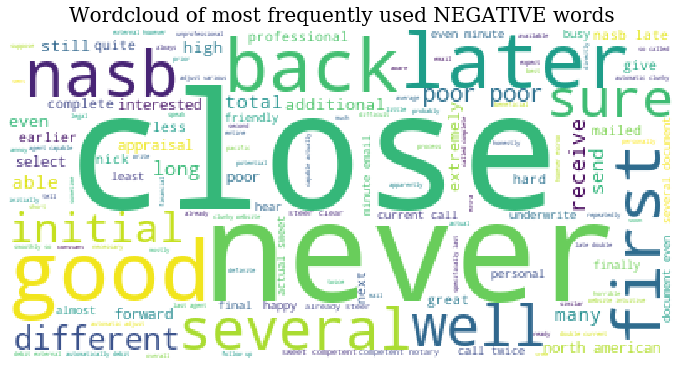

In [147]:
wordcloud = WordCloud(background_color='white',
                     ).generate(negative) 

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.title('Wordcloud of most frequently used NEGATIVE words',fontdict={'fontfamily':'serif','fontsize':20})
plt.show()

### Conclusion:

**NASB(North American Savings Bank)** seems to have the majority negative review.